<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Preprocess-10X" data-toc-modified-id="Preprocess-10X-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocess 10X</a></span></li><li><span><a href="#Load-10X" data-toc-modified-id="Load-10X-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load 10X</a></span></li><li><span><a href="#Reduce-dimensions" data-toc-modified-id="Reduce-dimensions-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Reduce dimensions</a></span></li><li><span><a href="#Merge-samples" data-toc-modified-id="Merge-samples-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Merge samples</a></span></li></ul></li><li><span><a href="#Main" data-toc-modified-id="Main-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Main</a></span><ul class="toc-item"><li><span><a href="#Load-data-and-preprocess" data-toc-modified-id="Load-data-and-preprocess-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load data and preprocess</a></span></li><li><span><a href="#Create-metadata" data-toc-modified-id="Create-metadata-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Create metadata</a></span></li><li><span><a href="#Reduce-dimensions" data-toc-modified-id="Reduce-dimensions-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Reduce dimensions</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Clustering</a></span></li></ul></li></ul></div>

# Imports

In [7]:
!pip install phate scprep umap-learn tasklogger magic-impute louvain seaborn
!pip install git+https://github.com/jacoblevine/phenograph.git

You should consider upgrading via the 'c:\users\stéphane\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Using legacy setup.py install for umap-learn, since package 'wheel' is not installed.
Using legacy setup.py install for future, since package 'wheel' is not installed.
Using legacy setup.py install for wrapt, since package 'wheel' is not installed.
    Running setup.py install for future: started
    Running setup.py install for future: finished with status 'done'
    Running setup.py install for wrapt: started
    Running setup.py install for wrapt: finished with status 'done'
    Running setup.py install for umap-learn: started
    Running setup.py install for umap-learn: finished with status 'done'
  Cloning https://github.com/jacoblevine/phenograph.git to c:\users\stphan~1\appdata\local\temp\pip-req-build-m3y2ag76
Using legacy setup.py install for PhenoGraph, since package 'wheel' is not installed.
    Running setup.py install for PhenoGraph: started
    Running setup.py install for PhenoGraph: finished with status 'done'


  Running command git clone -q https://github.com/jacoblevine/phenograph.git 'C:\Users\STPHAN~1\AppData\Local\Temp\pip-req-build-m3y2ag76'
You should consider upgrading via the 'c:\users\stéphane\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
import sklearn.cluster
import sklearn.manifold

import scprep
import os
import tasklogger
import phate
import umap

import graphtools as gt
import magic
import phenograph
import louvain

from sklearn.decomposition import PCA


ModuleNotFoundError: No module named 'seaborn'

# Functions

## Preprocess 10X

In [17]:
#' This function takes a data-frame (genes x cells), 
#' creates a Scprep object with it and filters the object for default tags such as  
#' Min and max nFeature_RNA and % of MT
#' 
#'
#' @param data data-frame
#' @param percent_mt integer [0-100]
#' @param max_features integer [0-Inf]
#' @param min_features integer [0-Inf]
#' @return Preprocessed Seurat object
#' @export

def preprocess_10X(data, name='10X-project', percent_mt=20, max_features=5000, min_features=200):
    
    #Remove empty cells and empty genes
    data = scprep.filter.filter_empty_cells(data)
    data = scprep.filter.filter_empty_genes(data)
    
    #Remove elements based on mythocondrial percentage
    mt_genes = scprep.select.get_gene_set(data, starts_with=["MT-", "mt-"])
    data = scprep.filter.filter_gene_set_expression(data=data, genes=mt_genes, percentile=100-percent_mt, keep_cells='below')
    
    #Remove elements based on number of cell and number of features
    data = scprep.filter.filter_library_size(data=data, cutoff=(min_features, max_features), keep_cells='between')
    data = scprep.filter.filter_rare_genes(data=data, cutoff=0, min_cells=3)

    return data

## Load 10X

In [3]:
# This function takes the path to a 10X output folder and instanciates the Scprep object
#
# @param file string (path to file)
# @param percent_mt integer [0-100]
# @param max_features integer [0-Inf]
# @param min_features integer [0-Inf]
# @return Preprocessed Seurat object
# @export

def load_10X(dir_path, name='10X-project',percent_mt=20, max_features=5000, min_features=200):
    data = scprep.io.load_10X(dir_path, sparse=True, gene_labels='both')
    return preprocess_10X(data=data, percent_mt=percent_mt, max_features=max_features, min_features=min_features)


## Reduce dimensions

In [4]:
# This function reduces the dimensions of the Normalized Seurat object
# Runs PCA and then UMAP and then performs clustering

# @param seurat.obj S4 instance
# @param ndims integer [3-100]
# @param res double [0-3]
# @return Seurat object with reduction embeddings
# @export

def reduce_dim(data, ndims=15, res=.1):
    data = scprep.normalize.library_size_normalize(data)
    data = scprep.utils.matrix_transform(data, np.sqrt)


    return data

## Merge samples

In [5]:
# Merge samples 
#
# 
# This function allows to instantiate a merged Seurat object of several distinct samples
# 
#
# @param files character vector of the files to merge 
# @return Merged Seurat object 
# @export

def merge_samples(dir_paths, labels, name='10X-project',percent_mt=20, max_features=5000, min_features=200):
    
    # Declare empty array T
    T=[]
    
    #Loading all files
    for dp in dir_paths:
        T.append(scprep.io.load_10X(dp, sparse=True, gene_labels='both'))
        
    #Merge samples
    data, sample_labels = scprep.utils.combine_batches(
        data=T,
        batch_labels=labels,
        append_to_cell_names=True
    )
    
    # Delete T to save space
    for t in T:
        del t

    return preprocess_10X(data, name, percent_mt, max_features, min_features), sample_labels

# Main

## Load data and preprocess

In [6]:

dir_paths = [
    "../data/14_EAE_all_cells.MPS12344479-A02.sorted.1229.merged.10x_outputs/filtered_feature_bc_matrix",
#     "../data/15_EAE_all_cells.MPS12344479-B02.sorted.1229.merged.10x_outputs/filtered_feature_bc_matrix",
#     "../data/16_WT_all_cells.MPS12344479-H01.sorted.1229.merged.10x_outputs/filtered_feature_bc_matrix"
]

lables = [
    "14_EAE", 
#     "15_EAE", 
#     "16_WT"
]

data,sample_labels = merge_samples(dir_paths=dir_paths, labels=lables, percent_mt=20, max_features=5000, min_features=200)

# seurat_path = "../../tutorials/seurat_guidedClustering/seurat_clusteringTutorial/filtered_gene_bc_matrices/hg19"
# data = load_10X(dir_path=seurat_path, percent_mt=20, max_features=5000, min_features=200)
data.head()


,0610009B22Rik (ENSMUSG00000007777),0610009O20Rik (ENSMUSG00000024442),0610010F05Rik (ENSMUSG00000042208),0610010K14Rik (ENSMUSG00000020831),0610012G03Rik (ENSMUSG00000107002),0610030E20Rik (ENSMUSG00000058706),0610037L13Rik (ENSMUSG00000028608),0610039K10Rik (ENSMUSG00000058812),0610040B10Rik (ENSMUSG00000089889),0610040J01Rik (ENSMUSG00000060512),...,mt-Co2 (ENSMUSG00000064354),mt-Co3 (ENSMUSG00000064358),mt-Cytb (ENSMUSG00000064370),mt-Nd1 (ENSMUSG00000064341),mt-Nd2 (ENSMUSG00000064345),mt-Nd3 (ENSMUSG00000064360),mt-Nd4 (ENSMUSG00000064363),mt-Nd4l (ENSMUSG00000065947),mt-Nd5 (ENSMUSG00000064367),mt-Nd6 (ENSMUSG00000064368)
AAACCTGGTATCGCAT-1_14_EAE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,9.0,5.0,2.0,2.0,1.0,1.0,8.0,0.0,0.0
AAACGGGAGAACTGTA-1_14_EAE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,5.0,6.0,6.0,3.0,0.0,1.0,4.0,1.0,0.0
AAACGGGGTTCTCATT-1_14_EAE,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,7.0,9.0,8.0,4.0,6.0,1.0,3.0,17.0,0.0,1.0
AAACGGGGTTCTGAAC-1_14_EAE,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,13.0,15.0,10.0,3.0,6.0,0.0,4.0,18.0,2.0,0.0
AAAGATGCAATGACCT-1_14_EAE,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,26.0,12.0,20.0,6.0,5.0,1.0,2.0,18.0,3.0,1.0


## Create metadata

In [7]:
sample_labels = pd.Series(sample_labels, index=data.index, name = "sample_labels")

libsize = scprep.measure.library_size(data)
libsize.name='library_size'

metadata = pd.concat([sample_labels, libsize], axis=1)
metadata


,sample_labels,library_size
AAACCTGGTATCGCAT-1_14_EAE,14_EAE,2460.0
AAACGGGAGAACTGTA-1_14_EAE,14_EAE,1154.0
AAACGGGGTTCTCATT-1_14_EAE,14_EAE,3948.0
AAACGGGGTTCTGAAC-1_14_EAE,14_EAE,4312.0
AAAGATGCAATGACCT-1_14_EAE,14_EAE,4118.0
...,...,...
TTTGGTTCAAGTACCT-1_14_EAE,14_EAE,593.0
TTTGTCAAGGGTTCCC-1_14_EAE,14_EAE,4714.0
TTTGTCACATCTGGTA-1_14_EAE,14_EAE,2870.0
TTTGTCATCAAGAAGT-1_14_EAE,14_EAE,2284.0


## Reduce dimensions

In [8]:
reduce_dim(data)

,0610009B22Rik (ENSMUSG00000007777),0610009O20Rik (ENSMUSG00000024442),0610010F05Rik (ENSMUSG00000042208),0610010K14Rik (ENSMUSG00000020831),0610012G03Rik (ENSMUSG00000107002),0610030E20Rik (ENSMUSG00000058706),0610037L13Rik (ENSMUSG00000028608),0610039K10Rik (ENSMUSG00000058812),0610040B10Rik (ENSMUSG00000089889),0610040J01Rik (ENSMUSG00000060512),...,mt-Co2 (ENSMUSG00000064354),mt-Co3 (ENSMUSG00000064358),mt-Cytb (ENSMUSG00000064370),mt-Nd1 (ENSMUSG00000064341),mt-Nd2 (ENSMUSG00000064345),mt-Nd3 (ENSMUSG00000064360),mt-Nd4 (ENSMUSG00000064363),mt-Nd4l (ENSMUSG00000065947),mt-Nd5 (ENSMUSG00000064367),mt-Nd6 (ENSMUSG00000064368)
AAACCTGGTATCGCAT-1_14_EAE,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,3.492151,6.048584,4.508348,2.851330,2.851330,2.016195,2.016195,5.702659,0.000000,0.000000
AAACGGGAGAACTGTA-1_14_EAE,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,5.887448,6.582367,7.210622,7.210622,5.098680,0.000000,2.943724,5.887448,2.943724,0.000000
AAACGGGGTTCTCATT-1_14_EAE,0.0,0.0,0.0,0.000000,1.591518,0.000000,0.0,0.0,0.0,1.591518,...,4.210760,4.774553,4.501491,3.183035,3.898406,1.591518,2.756589,6.561995,0.000000,1.591518
AAACGGGGTTCTGAAC-1_14_EAE,0.0,0.0,0.0,0.000000,1.522862,0.000000,0.0,0.0,0.0,1.522862,...,5.490758,5.898020,4.815713,2.637675,3.730235,0.000000,3.045725,6.460957,2.153652,0.000000
AAAGATGCAATGACCT-1_14_EAE,0.0,0.0,0.0,1.558321,0.000000,1.558321,0.0,0.0,0.0,0.000000,...,7.945907,5.398181,6.969022,3.817090,3.484511,1.558321,2.203798,6.611395,2.699091,1.558321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAAGTACCT-1_14_EAE,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,7.112680,4.106508,7.112680,0.000000,0.000000,0.000000,0.000000,8.213016,0.000000,0.000000
TTTGTCAAGGGTTCCC-1_14_EAE,0.0,0.0,0.0,0.000000,1.456482,1.456482,0.0,0.0,0.0,0.000000,...,7.568104,7.135277,4.605801,3.853490,3.567638,1.456482,2.912965,4.605801,2.059777,0.000000
TTTGTCACATCTGGTA-1_14_EAE,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,4.173919,2.639818,1.866633,0.000000,0.000000,0.000000,0.000000,2.639818,1.866633,0.000000
TTTGTCATCAAGAAGT-1_14_EAE,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,4.678827,3.624204,6.277305,3.624204,0.000000,0.000000,2.959150,4.678827,2.959150,0.000000


## Clustering

In [11]:
data_pca, singular_values = scprep.reduce.pca(data, n_components=100, return_singular_values=True)


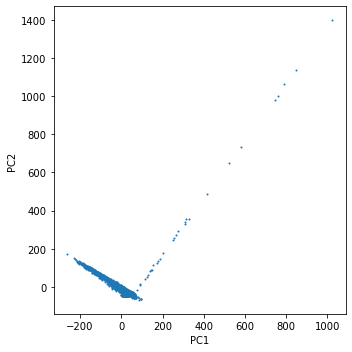

In [13]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.scatter(data_pca.values[:,0], data_pca.values[:,1], s=1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

fig.tight_layout()


<AxesSubplot:xlabel='Principal Component', ylabel='Explained Variance (%)'>

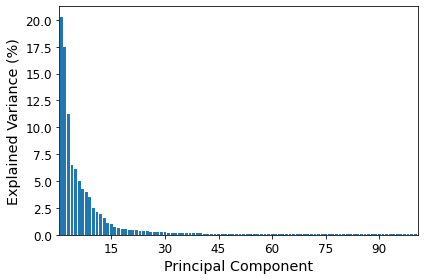

In [14]:
scprep.plot.scree_plot(singular_values)

In [15]:
data_phate = phate.PHATE().fit_transform(data)

Calculating PHATE...
  Running PHATE on 2088 observations and 15131 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.73 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.64 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 4.71 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.32 seconds.
    Calculating KMeans...
    Calculated KMeans in 16.48 seconds.
  Calculated landmark operator in 18.34 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 6.43 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.79 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.00 seconds.
Calculated PHATE in 41.28 seconds.


C:\Users\sburw\AppData\Roaming\Python\Python37\site-packages\scprep\plot\tools.py:255: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  extent=[xmin, xmax, ymin, ymax],


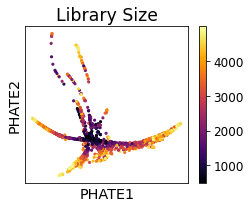

In [18]:
# Plotting libsize
fig, ax = plt.subplots(1, figsize=(3.6,3))
scprep.plot.scatter2d(data_phate, ax=ax, c=metadata['library_size'],
                      title='Library Size', ticks=False, label_prefix='PHATE')
fig.tight_layout()